# CS-VQE for Solving Electronic Structure

The second-quantised molecular Hailtonian takes the form

\begin{equation}
H = \sum_{pq} h_{pq} \hat{a}^*_p \hat{a}_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} \hat{a}^*_p \hat{a}^*_q \hat{a}_r \hat{a}_s
\end{equation}

where $\hat{a}$ is the Fermionic annihiliation operator, with its adjoint $\hat{a}^*$ the creation operator. We may map this Hamiltonian onto qubits via some transformation such as Jordan-Wigner, where

\begin{equation}
\hat{a}_p \mapsto \frac{1}{2} (X_p + i Y_p) \otimes \bigotimes_{q<p} Z_q.
\end{equation}
Let us see what this Hamiltonian looks like in practice:

In [43]:
import numpy as np
import os
import json
from matplotlib import pyplot as plt

cwd = os.getcwd()
notebook_dir =  os.path.dirname(cwd)
symmer_dir = os.path.dirname(notebook_dir)
test_dir = os.path.join(symmer_dir, 'tests')
ham_data_dir = os.path.join(test_dir, 'hamiltonian_data')

if not os.path.isdir(ham_data_dir):
    raise ValueError('cannot find data dir')
    
filename = 'Be_STO-3G_SINGLET_JW.json'

if filename not in os.listdir(ham_data_dir):
    raise ValueError('unknown file')
    
with open(os.path.join(ham_data_dir, filename), 'r') as infile:
    data_dict = json.load(infile)

In [44]:
data_dict['data']

{'qubit_encoding': 'jordan_wigner',
 'unit': 'angstrom',
 'geometry': '1\n \nBe\t0\t0\t0',
 'basis': 'sto-3g',
 'charge': 0,
 'spin': 0,
 'hf_array': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 'hf_method': 'pyscf.scf.hf_symm.SymAdaptedRHF',
 'n_particles': 4,
 'n_qubits': 10,
 'convergence_threshold': 1e-06,
 'point_group': {'groupname': 'SO3', 'topgroup': 'SO3'},
 'calculated_properties': {'HF': {'energy': -14.351880476202012,
   'converged': True},
  'MP2': {'energy': -14.376238850841505, 'converged': True},
  'CCSD': {'energy': -14.40365075175297, 'converged': True},
  'FCI': {'energy': -14.403655108067653, 'converged': True}},
 'auxiliary_operators': {'number_operator': {'IIIIIIIIII': [5.0, 0.0],
   'IIIIIIIIIZ': [-0.5, 0.0],
   'IIIIIIIIZI': [-0.5, 0.0],
   'IIIIIIIZII': [-0.5, 0.0],
   'IIIIIIZIII': [-0.5, 0.0],
   'IIIIIZIIII': [-0.5, 0.0],
   'IIIIZIIIII': [-0.5, 0.0],
   'IIIZIIIIII': [-0.5, 0.0],
   'IIZIIIIIII': [-0.5, 0.0],
   'IZIIIIIIII': [-0.5, 0.0],
   'ZIIIIIIIII': [-0.5, 0.0]},

In [45]:
from symmer.symplectic import PauliwordOp

fci_energy = data_dict['data']['calculated_properties']['FCI']['energy']
hf_array   = np.asarray(data_dict['data']['hf_array'])
H = PauliwordOp.from_dictionary(data_dict['hamiltonian'])
print(H)

-9.009+0.000j IIIIIIIIII +
-0.148+0.000j IIIIIIIIIZ +
-0.148+0.000j IIIIIIIIZI +
 0.112+0.000j IIIIIIIIZZ +
-0.148+0.000j IIIIIIIZII +
 0.094+0.000j IIIIIIIZIZ +
 0.100+0.000j IIIIIIIZZI +
-0.148+0.000j IIIIIIZIII +
 0.100+0.000j IIIIIIZIIZ +
 0.094+0.000j IIIIIIZIZI +
 0.112+0.000j IIIIIIZZII +
-0.148+0.000j IIIIIZIIII +
 0.094+0.000j IIIIIZIIIZ +
 0.100+0.000j IIIIIZIIZI +
 0.094+0.000j IIIIIZIZII +
 0.100+0.000j IIIIIZZIII +
-0.148+0.000j IIIIZIIIII +
 0.100+0.000j IIIIZIIIIZ +
 0.094+0.000j IIIIZIIIZI +
 0.100+0.000j IIIIZIIZII +
 0.094+0.000j IIIIZIZIII +
 0.112+0.000j IIIIZZIIII +
-0.047+0.000j IIIZIIIIII +
 0.081+0.000j IIIZIIIIIZ +
 0.102+0.000j IIIZIIIIZI +
 0.081+0.000j IIIZIIIZII +
 0.102+0.000j IIIZIIZIII +
 0.081+0.000j IIIZIZIIII +
 0.102+0.000j IIIZZIIIII +
-0.047+0.000j IIZIIIIIII +
 0.102+0.000j IIZIIIIIIZ +
 0.081+0.000j IIZIIIIIZI +
 0.102+0.000j IIZIIIIZII +
 0.081+0.000j IIZIIIZIII +
 0.102+0.000j IIZIIZIIII +
 0.081+0.000j IIZIZIIIII +
 0.101+0.000j IIZZIIIIII +
 

Note that the ground state energy of this Hamiltonian matches the full-configuration interaction (FCI) energy above

In [46]:
from symmer.utils import exact_gs_energy
from symmer.symplectic import QuantumState

gs_nrg, gs_psi = exact_gs_energy(H.to_sparse_matrix)

print(f'Ground state energy = {gs_nrg}, with FCI error {abs(gs_nrg - fci_energy)}.\n')
print('The ground state is:\n'); print(gs_psi)

Ground state energy = -14.403655108067865, with FCI error 2.113864638886298e-13.

The ground state is:

 0.000-0.001j |0000001111> +
 0.000-0.001j |0000110011> +
 0.000-0.001j |0000111100> +
-0.000+0.001j |0011000011> +
-0.000+0.001j |0011001100> +
-0.000+0.001j |0011110000> +
-0.001+0.003j |0110000011> +
-0.001+0.003j |0110001100> +
-0.001+0.003j |0110110000> +
 0.001-0.003j |1001000011> +
 0.001-0.003j |1001001100> +
 0.001-0.003j |1001110000> +
-0.000-0.000j |1100000000> +
-0.000+0.000j |1100000001> +
 0.000-0.000j |1100000010> +
-0.044+0.181j |1100000011> +
-0.000-0.000j |1100000100> +
 0.000+0.000j |1100000110> +
-0.000+0.000j |1100000111> +
 0.000-0.000j |1100001000> +
-0.000-0.000j |1100001001> +
-0.000+0.000j |1100001011> +
-0.044+0.181j |1100001100> +
-0.000-0.000j |1100001101> +
 0.000+0.000j |1100001110> +
 0.000-0.000j |1100010000> +
 0.000-0.000j |1100010010> +
 0.000+0.000j |1100010011> +
-0.000+0.000j |1100010101> +
 0.000+0.000j |1100010110> +
-0.000+0.000j |1100011000>

# Taper the Hamiltonian first

Before we apply CS-VQE, one might as well perform qubit tapering since it does not introduce any systematic error

In [47]:
from symmer.projection import QubitTapering

QT = QubitTapering(H)
print(f'Qubit tapering permits a reduction of {H.n_qubits} -> {H.n_qubits-QT.n_taper} qubits.\n')
print('The following symmetry generators were identified:\n')
print(QT.symmetry_generators); print()
print('which we may rotate onto the single-qubit Pauli operators\n') 
print(QT.symmetry_generators.rotate_onto_single_qubit_paulis()); print()
print('via a sequence of Clifford operations R_k = e^{i pi/4 P_k} where:\n')
for index, (P_k, angle) in enumerate(QT.symmetry_generators.stabilizer_rotations):
    P_k.sigfig=0
    print(f'P_{index} = {P_k}')

Qubit tapering permits a reduction of 10 -> 5 qubits.

The following symmetry generators were identified:

 1 IIIIIIIIZZ 
 1 IIIIIIZZII 
 1 IIIIZZIIII 
 1 IZIZIZIZIZ 
 1 ZIZIIZIZIZ

which we may rotate onto the single-qubit Pauli operators

-1 IIIIIIIIXI 
-1 IIIIIIXIII 
-1 IIIIXIIIII 
-1 IXIIIIIIII 
-1 XIIIIIIIII

via a sequence of Clifford operations R_k = e^{i pi/4 P_k} where:

P_0 =  1+0j IIIIIIIIYZ
P_1 =  1+0j IIIIIIYZII
P_2 =  1+0j IIIIYZIIII
P_3 =  1+0j IYIZIZIZIZ
P_4 =  1+0j YIZIIZIZIZ


In [49]:
UCC_q = PauliwordOp.from_dictionary(data_dict['data']['auxiliary_operators']['UCCSD_operator'])

H_taper = QT.taper_it(ref_state=hf_array) 
UCC_taper = QT.taper_it(aux_operator=UCC_q)
# note the reference state to place us in the correct symmetry sector!

gs_nrg_tap, gs_psi_tap = exact_gs_energy(H_taper.to_sparse_matrix)

print(f'The ground state energy of the Hamiltonian is {gs_nrg}')
print(f'and for the {H_taper.n_qubits}-qubit tapered Hamiltonian it is {gs_nrg_tap};')
print(f'the energy error is {abs(gs_nrg - gs_nrg_tap)}.\n')
print('The tapered ground state is:\n')
print(gs_psi_tap)

The ground state energy of the Hamiltonian is -14.403655108067865
and for the 5-qubit tapered Hamiltonian it is -14.403655108067657;
the energy error is 2.078337502098293e-13.

The tapered ground state is:

 0.186+0.000j |00001> +
 0.186+0.000j |00010> +
 0.001+0.000j |00011> +
 0.186+0.000j |00100> +
 0.001+0.000j |00101> +
 0.001+0.000j |00110> +
 0.003+0.000j |01001> +
 0.003+0.000j |01010> +
 0.003+0.000j |01100> +
-0.003+0.000j |10001> +
-0.003+0.000j |10010> +
-0.003+0.000j |10100> +
 0.946+0.000j |11000> +
 0.001+0.000j |11001> +
 0.001+0.000j |11010> +
 0.001+0.000j |11100>


# Now we build the CS-VQE model

This involves partitioning $H$ into _noncontextual_ and _contextual_ componenents satisfying $H = H_\mathrm{noncon} + H_\mathrm{context}$.

In [50]:
from symmer.projection import ContextualSubspace

cs_vqe = ContextualSubspace(H_taper, noncontextual_strategy='SingleSweep_magnitude')

Noncontextual Hamiltonians have a very specific form, namely their terms $\mathcal{T}$ may be decomposed as
\begin{equation}
    \mathcal{T} = \mathcal{S} \cup \mathcal{C}_1 \cup \dots \cup \mathcal{C}_M 
\end{equation}
where $\mathcal{S}$ contains the terms that commute globally (i.e. the noncontextual symmetries) and a collection of cliques with respect to commutation.

In [51]:
cs_vqe.noncontextual_operator.decomposed

{'symmetry': -8.672+0.000j IIIII +
  2.243-0.000j ZIZZZ +
  0.389+0.000j IIZZI +
  0.389+0.000j IIIZZ +
  0.389+0.000j IIZIZ +
 -0.297+0.000j IIZII +
 -0.297+0.000j IIIZI +
 -0.297+0.000j IIIIZ +
  0.281+0.000j ZIZZI +
  0.281+0.000j ZIZIZ +
  0.281+0.000j ZIIZZ +
  0.263-0.000j IIZZZ +
  0.183+0.000j ZIIIZ +
  0.183+0.000j ZIIZI +
  0.183+0.000j ZIZII +
 -0.047+0.000j ZIIII,
 'clique_0':  0.060+0.000j IXIII +
 -0.060+0.000j IXZZZ +
 -0.038+0.000j ZXIII +
 -0.010+0.000j ZXIIZ +
 -0.010+0.000j ZXIZI +
  0.010+0.000j ZXIZZ +
 -0.010+0.000j ZXZII +
  0.010+0.000j ZXZIZ +
  0.010+0.000j ZXZZI +
  0.038+0.000j ZXZZZ,
 'clique_1': -0.047+0.000j IZIII +
  0.183+0.000j IZIIZ +
  0.183+0.000j IZIZI +
  0.281+0.000j IZIZZ +
  0.183+0.000j IZZII +
  0.281+0.000j IZZIZ +
  0.281+0.000j IZZZI +
  2.243-0.000j IZZZZ +
  0.670+0.000j ZZIII +
  0.286-0.000j ZZZZZ}

Representing the Hamiltonian as a graph with edges denoting commutation between Pauli operators, this structure corresponds with a partition into complete subgraphs:

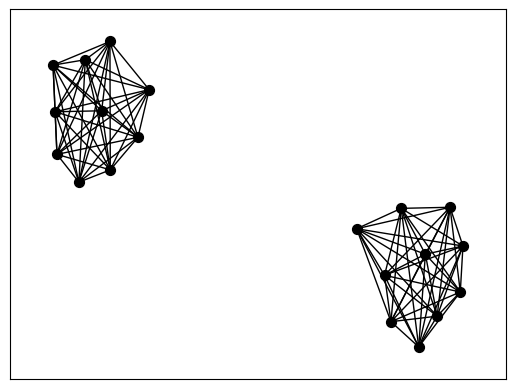

In [52]:
from symmer.symplectic import ObservableGraph, PauliwordOp
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

adjmat = cs_vqe.noncontextual_operator.adjacency_matrix.copy()
mask_nonsymmetries = ~np.all(adjmat, axis=1)
adjmat = adjmat[mask_nonsymmetries,:][:,mask_nonsymmetries]
np.fill_diagonal(adjmat, False)
graph = nx.from_numpy_matrix(adjmat)

plt.figure()
pos = nx.spring_layout(graph, k=1)
nx.draw_networkx_nodes(graph,pos,node_color='black', node_size=50)
nx.draw_networkx_edges(graph, pos,width=1)
plt.show()

Identifying a generating set $\mathcal{G}$ for the symmetry terms $\mathcal{S}$ and constructing the clique operator $A(\vec{r}) = \sum_{i=1}^M r_i C_i$ for clique representatives $C_i \in \mathcal{C}_i$ and coefficients $\vec{r} \in \mathbb{R}^M$ satisfying $|\vec{r}|=1$ allows us to rewrite

\begin{equation}
    H_\mathrm{noncon} = \sum_{P \in \overline{\mathcal{G}}} \bigg(h_{P}^\prime + \sum_{i=1}^M h_{P,i} C_i \bigg) P,
\end{equation}

and yields a classical objective function over parameters $\vec{\nu} \in \{\pm 1\}^{|\mathcal{G}|}$ and $\vec{r} \in \mathbb{R}^M$ for the noncontetual energy expectation value:

\begin{equation}\label{classical_objective}
\begin{aligned}
    \eta(\vec{\nu}, \vec{r}) 
    :={} & {\langle H_\mathrm{noncon} \rangle_{(\vec{\nu}, \vec{r})}} \\
    ={} & \sum_{P \in \overline{\mathcal{G}}} \bigg(h_{P}^\prime + \sum_{i=1}^M h_{P,i} \langle{C_i}\rangle_{(\vec{\nu}, \vec{r})} \bigg) \langle{P}\rangle_{(\vec{\nu}, \vec{r})} \\
    ={} & \sum_{P \in \overline{\mathcal{G}}} \bigg(h_{P}^\prime + \sum_{i=1}^M h_{P,i} r_i \bigg) \prod_{G \in \mathcal{G}_{P}} \nu_{f(G)}.
\end{aligned}
\end{equation}

In [53]:
print('The symmetry generators G are:\n')
print(cs_vqe.noncontextual_operator.symmetry_generators); print()
print('The clique operator A(r) is:\n')
print(cs_vqe.noncontextual_operator.clique_operator); print()
print(f'The optimal paramters are '+ 
      f'nu={cs_vqe.noncontextual_operator.symmetry_generators.coeff_vec}, r={cs_vqe.noncontextual_operator.clique_operator.coeff_vec},')
print(f'which yields a noncontextual energy of n(nu,r) = {cs_vqe.noncontextual_operator.energy}')

The symmetry generators G are:

 1 IIIIZ 
 1 IIIZI 
 1 IIZII 
-1 ZIIII

The clique operator A(r) is:

-0.000 IXIII +
-1.000 IZIII

The optimal paramters are nu=[ 1  1  1 -1], r=[-1.39637415e-08 -1.00000000e+00],
which yields a noncontextual energy of n(nu,r) = -14.351880476202016


# Quantum corrections

We have obtained a classical estimate to the ground state energy from the noncontextual Hamiltonian - the power of CS-VQE is in how it derives quantum corrections from a VQE simulation of the contextual Hamiltonian. To ensure the corrections are valid, we constrain the contextual problem by the solution to the noncontextual one. This is achieved via stabilizer subspace projections - similar in vain to tapering, except the imposed symmetries are those of the noncontextual Hamiltonian. This results in a loss of information, since symmetry-breaking terms vanish under such a projection. 

We choose a set of stabilizers $\mathcal{F}$ we would like to fix in the contextual subspace; identifying a unitary operation $U_\mathcal{F}$ mapping $\mathcal{F}$ to single-qubit Pauli operators we may obtain a reduced $(N-|\mathcal{F}|)$-qubit Hamiltonian

\begin{equation}
    \tilde{H}= \pi_{U_{\mathcal{F}}} (H_\mathrm{context})
\end{equation}

with the projection $\pi(\cdot)$ defined in [this](https://arxiv.org/pdf/2204.02150.pdf) paper.

In [54]:
cs_vqe.update_stabilizers(n_qubits = 3, strategy='aux_preserving', aux_operator=UCC_taper)
# the user may specify stabilizers manually also:
# cs_vqe.manual_stabilizers(['ZIZZZ', 'ZZIII'])

H_cs = cs_vqe.project_onto_subspace()
print(f'We may project into the contextual subspace stabilized by '+
      f'{list(cs_vqe.stabilizers.to_dictionary.keys())} via a sequence of rotations:\n')

if cs_vqe.perform_unitary_partitioning:
    print(f'Note the clique operator')
    print(cs_vqe.noncontextual_operator.clique_operator) 
    print('is enforced for this set of stabilizers.')
#for index, (P_k, angle) in enumerate(
#    cs_vqe.unitary_partitioning_rotations+cs_vqe.stabilizers.stabilizer_rotations
#    ):
#    P_k.sigfig=0
#    print(f'P_{index} = {P_k}')
    
print(f'\nand tracing over qubit positions {cs_vqe.stab_qubit_indices} yields the {H_cs.n_qubits}-qubit Hamiltonian:\n')
print(H_cs)

We may project into the contextual subspace stabilized by ['IZZZZ', 'ZIZZZ'] via a sequence of rotations:

Note the clique operator
-0.000 IXIII +
-1.000 IZIII
is enforced for this set of stabilizers.

and tracing over qubit positions [1 0] yields the 3-qubit Hamiltonian:

-12.489+0.000j III +
-0.858+0.000j IIZ +
-0.858+0.000j IZI +
 0.023+0.000j IZZ +
-0.858+0.000j ZII +
 0.023+0.000j ZIZ +
 0.023+0.000j ZZI +
 0.642+0.000j ZZZ +
-0.043+0.000j IIX +
-0.043+0.000j ZZX +
-0.043+0.000j IXI +
-0.043+0.000j ZXZ +
 0.012+0.000j IXX +
 0.012+0.000j IYY +
-0.043+0.000j XII +
-0.043+0.000j XZZ +
 0.012+0.000j XIX +
 0.012+0.000j YIY +
 0.012+0.000j XXI +
 0.012+0.000j YYI


In [55]:
cs_vqe.stabilizers.stabilizer_rotations

[( 1.000+0.000j YIZZZ, None),
 ( 1.000+0.000j IYZZZ, None),
 ( 1.000+0.000j IYIII, None),
 ( 1.000+0.000j YIIII, None)]

In [56]:
cs_vqe.unitary_partitioning_rotations

 0.000+0.000j IIIII +
-0.000-1.000j IYIII

Performing a VQE simulation over this Hamiltonian yields the quantum-corrected energy

In [59]:
from symmer.symplectic import ObservableOp, AnsatzOp

UCC_cs = cs_vqe.project_onto_subspace(UCC_taper)
obs_cs = ObservableOp(H_cs.symp_matrix, H_cs.coeff_vec)
anz_cs = AnsatzOp(UCC_cs.symp_matrix, np.random.random(UCC_cs.n_terms))
ref_cs = hf_array[QT.free_qubit_indices][cs_vqe.free_qubit_indices]

vqe_result, interim_data = obs_cs.VQE(
    ansatz_op=anz_cs, 
    ref_state=ref_cs,
    optimizer='BFGS',
    maxiter=20
)
print(f'Converged VQE energy = {vqe_result.fun} with FCI error {abs(vqe_result.fun-fci_energy)}')

Converged VQE energy = -14.403023745018029 with FCI error 0.0006313630496244116


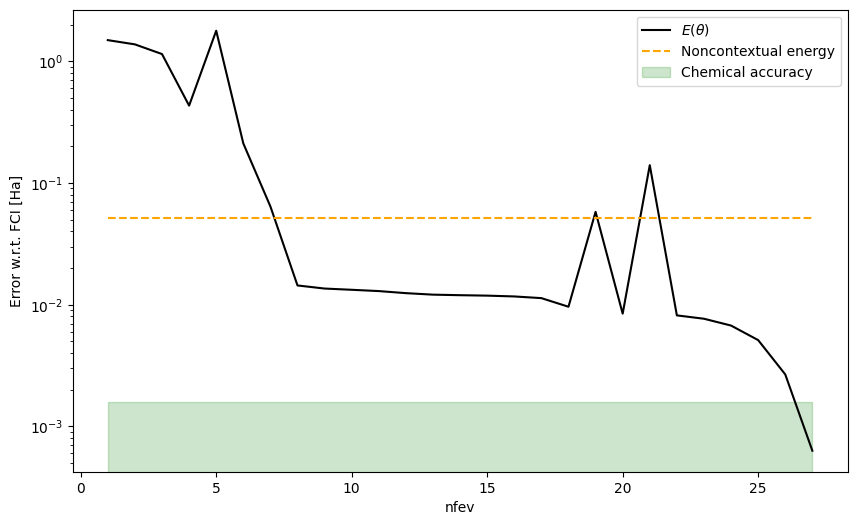

In [61]:
fig, axis = plt.subplots(figsize=(10,6))

X,Y = zip(*interim_data['values'])
axis.plot(X, abs(np.array(Y)-fci_energy), color='black', label='$E(\\theta)$')
axis.hlines(abs(cs_vqe.noncontextual_operator.energy-fci_energy), 1, X[-1], color='orange', ls='--', label='Noncontextual energy')
axis.fill_between(X, 0, 0.0016, color='green', alpha=0.2, label='Chemical accuracy')
axis.set_yscale('log')
axis.set_ylabel('Error w.r.t. FCI [Ha]')
axis.set_xlabel('nfev')
axis.legend()
plt.show()